# Multi-layer Perceptron(MLP)

## Install Library & requirements

In [ ]:
!pwd

In [2]:
import os
import sys
from datetime import datetime

drive_project_root = "/home/jmj3047/mj_MLP_prac"
sys.path.append(drive_project_root)


In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch_optimizer import RAdam
from torch_optimizer import AdamP

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import wandb

In [4]:
#!pwd
data_root = os.path.join(os.getcwd(), 'data')

#preprocessing & 데이터 셋 정의
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5]) #mean, std
    ]
)

fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform=transform)


## DataLoader 정의

In [5]:
from torch.utils.data import random_split
from data_utils import dataset_split

In [6]:
datasets= dataset_split(fashion_mnist_dataset, split=[0.9,0.1])

train_dataset = datasets['train']
val_dataset = datasets['val']

train_batch_size = 100
val_batch_size = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = train_batch_size, shuffle=True, num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = val_batch_size, shuffle=True, num_workers=1
)

In [7]:
for sample_batch in train_dataloader:
    print(sample_batch[0].shape, sample_batch[1].shape)
    break

#torch.Size([100, 1, 28, 28]) batchsize, channel, width, height

torch.Size([100, 1, 28, 28]) torch.Size([100])


## 모델(Multi-Layer Perceptron) (MLP) 정의
## 모델 MLPWithDropout 정의

In [8]:
import torch. nn.functional as F

In [9]:
#Define Model

class MLP(nn.Module):
    def __init__(self, in_dim=int, h1_dim = int, h2_dim = int, out_dim = int):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, out_dim)
        self.relu = F.relu #activation 함수 정의

        pass

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        out = self.linear3(x)
        out = F.sigmoid(out) #binary classification은 softmax로 사용
        return out



class MLPWithDropout(MLP):
    def __init__(self, in_dim: int, h1_dim: int, h2_dim: int, out_dim: int, dropout_prob: float):
        super().__init__(in_dim, h1_dim, h2_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)
    
    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.dropout1(x)
        x = self.relu(self.linear2(x))
        x = self.dropout2(x)
        out = self.linear3(x)
        # out = F.softmax(out)
        return out


## Learning Rate Scheduler

In [11]:
#Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimpizer:optim.Optimizer, warmup_end_stops:int, last_epoch:int = -1):
        def warmup_fn(step:int):
            if step < warmup_end_stops:
                return float(step)/float(max(warmup_end_stops,1))
            return 1.0
        
        super().__init__(optimizer, warmup_fn, last_epoch)


## 모델 선언 및 손실함수, 최적화(Optimizer) 정의, Tensorboard Logger 정의

In [19]:
#define model
# model = MLP(28*28, 128, 64, 10)
model = MLPWithDropout(28*28, 128,64,10, dropout_prob=0.3)
model_name = type(model).__name__
print(model_name)

#define loss
loss_function = nn.CrossEntropyLoss()

#define optimizer
lr=1e-3
# optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.AdamP(model.parameters(), lr=lr)
optimizer_name = type(optimizer).__name__


#define scheduler
scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

max_epoch = 10

#define tensorboard logger
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
log_dir = f"runs/{run_name}"
writer = SummaryWriter(log_dir=log_dir)
# writer = SummaryWriter()
log_interval =100

#define wandb
project_name='fastcapmus_fashion_mnist_tutorials'
run_tags = [project_name]
wandb.init(
    project=project_name,
    name=run_name,
    tags=run_tags,
    config={"lr":lr, "model_name":model_name, "optimizer_name":optimizer_name, "scheduler_name": scheduler_name},
    reinit=True
)

# set save model path
log_model_path = os.path.join(log_dir, "models")
os.makedirs(log_model_path, exist_ok=True)

MLPWithDropout


Acc/train,▇▃▇▅▄▄▇▇▃▄▂▂█▁▆▂▂▄
Acc/val,█▄▁▆
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/train,▃▃▆█▄▃▁▃▂▃▃▅▁▆▅▇▅▃
Loss/val,▁█▁▄
Acc/train,0.09
Acc/val,0.09933
Learning Rate,0.0
Loss/train,0.02311
Loss/val,0.23134


In [15]:
# for i in range(250):
#     print("step",i)
#     optimizer.step()
#     scheduler.step()
#     print(scheduler.get_last_lr())
    

step 0
[6.666666666666667e-07]
step 1
[1.3333333333333334e-06]
step 2
[2e-06]
step 3
[2.666666666666667e-06]
step 4
[3.3333333333333337e-06]
step 5
[4e-06]
step 6
[4.666666666666667e-06]
step 7
[5.333333333333334e-06]
step 8
[6e-06]
step 9
[6.6666666666666675e-06]
step 10
[7.333333333333333e-06]
step 11
[8e-06]
step 12
[8.666666666666666e-06]
step 13
[9.333333333333334e-06]
step 14
[1e-05]
step 15
[1.0666666666666667e-05]
step 16
[1.1333333333333334e-05]
step 17
[1.2e-05]
step 18
[1.2666666666666667e-05]
step 19
[1.3333333333333335e-05]
step 20
[1.4e-05]
step 21
[1.4666666666666666e-05]
step 22
[1.5333333333333334e-05]
step 23
[1.6e-05]
step 24
[1.6666666666666667e-05]
step 25
[1.7333333333333332e-05]
step 26
[1.8e-05]
step 27
[1.866666666666667e-05]
step 28
[1.9333333333333333e-05]
step 29
[2e-05]
step 30
[2.0666666666666666e-05]
step 31
[2.1333333333333335e-05]
step 32
[2.2e-05]
step 33
[2.2666666666666668e-05]
step 34
[2.3333333333333336e-05]
step 35
[2.4e-05]
step 36
[2.46666666666

## Early Stopping callback Object Class 정의

In [16]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None: #loss가 최소화 됐을때 save_checkpoint를 저장함
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta: #모델 성능이 더이상 개선되지 않는다 했을 때 early stopping이 됨
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: #개선이 안됐다고 바로 하는게 아니라 조금 기다렸다가 stop함
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}")) #어떤 score에서 멈췄는지가 중요하기 때문에 그걸 print해줌
        self.val_loss_min = val_loss

In [20]:
%load_ext tensorboard
%tensorboard --logdir runs/ #여기다가 log를 쌓을거고 거기 있는걸 plot해달라는 의미

#define EarlyStopping
early_stopper = EarlyStopping(
    patience=3, verbose=True, path = os.path.join(log_model_path, "model.ckpt")
)

#do train with validation
train_step = 0
for epoch in range(1, max_epoch+1):
    #validation step
    with torch.no_grad(): # optimizer가 업데이트 하면 안됨
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc = 'validation')
        ):
            #forward
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            
            #loss & acc
            val_loss += loss_function(val_outputs, val_labels) / val_outputs.shape[0] #이게 batch size. batch size만큼 평균을 내겠다는 뜻
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0]
        
        #valid step logging
        val_epoch_loss = val_loss / len(val_dataloader)
        val_epoch_acc = val_corrects/len(val_dataloader)
        print(
            f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}" 
        )

        #tensorboard log
        writer.add_scalar("Loss/val", val_epoch_loss, train_step)
        writer.add_scalar("Acc/val", val_epoch_acc, train_step)
        writer.add_images("Images/val", val_images, train_step)

        #wandb log
        wandb.log({
            "Loss/val":val_epoch_loss,
            "Acc/val": val_epoch_acc,
            "Images/val": wandb.Image(val_images),
            "Outputs/val": wandb.Histogram(val_outputs.detach().numpy()),
            "Preds/val": wandb.Histogram(val_preds.detach().numpy()),
            "Labels/val": wandb.Histogram(val_labels.data.detach().numpy()),
        }, step=train_step)

        # check early stopping point & save model if model reached the best performance
        early_stopper(val_epoch_loss, model)
        if early_stopper.early_stop:
            break
        
        #train step
        current_loss = 0
        current_corrects = 0
        model
                



    #train step
    for batch_idx, (images, labels) in enumerate(
         tqdm(train_dataloader, position=0, leave=True, desc = 'train')
    ):
        current_loss = 0.0
        current_corrects = 0

        #get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # print(outputs)
        # print(preds)
        
        #get loss
        loss = loss_function(outputs, labels)


        ###### 여기까지가 forward ###

        #Backpropagation

        #optimitizer 초기화(zero화)
        optimizer.zero_grad()

        #perform backward pass
        loss.backward()

        #perfrom optimization
        optimizer.step()

        #Perform LR Scheduler work
        if scheduler is not None:
            scheduler.step()

        current_loss +=loss.item()
        current_corrects += torch.sum(preds == labels.data)

        if train_step % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = current_corrects/log_interval
            print(
                f"{train_step}: train_loss: {train_loss}, train_acc: {train_acc}" 
            )

            #tensorboard log
            writer.add_scalar("Loss/train", train_step)
            writer.add_scalar("Acc/train", train_step)
            writer.add_images("Images/train", images, train_step)
            writer.add_scalar("Learning Rate", scheduler.get_last_lr()[0],train_step)
            writer.add_graph(model, images)
            
            
            # wandb log
            wandb.log({
                "Loss/train": train_loss,
                "Acc/train": train_acc,
                "Images/train": wandb.Image(images),
                "Outputs/train": wandb.Histogram(outputs.detach().cpu().numpy()),
                "Preds/train": wandb.Histogram(preds.detach().cpu().numpy()),
                "Labels/train": wandb.Histogram(labels.data.detach().cpu().numpy()),
                "Learning Rate": scheduler.get_last_lr()[0], 
            }, step=train_step)

            current_loss = 0
            current_corrects = 0

        train_step += 1



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 31906), started 6:00:31 ago. (Use '!kill 31906' to kill it.)

train:   0%|          | 0/540 [00:00<?, ?it/s]

1 epoch, 0 step: val_loss: 0.23030848801136017, val_acc: 0.11349983513355255
Validation loss decreased (inf --> 0.230308).  Saving model ...
0: train_loss: 0.02321147680282593, train_acc: 0.05999999865889549


train:  19%|█▉        | 103/540 [00:03<00:17, 25.70it/s]

100: train_loss: 0.019636197090148924, train_acc: 0.4399999976158142


train:  37%|███▋      | 198/540 [00:05<00:08, 39.30it/s]

200: train_loss: 0.009831223487854004, train_acc: 0.6600000262260437


train:  56%|█████▌    | 301/540 [00:09<00:08, 29.02it/s]

300: train_loss: 0.006794642806053162, train_acc: 0.7099999785423279


train:  74%|███████▍  | 402/540 [00:12<00:04, 31.81it/s]

400: train_loss: 0.006486737132072449, train_acc: 0.7799999713897705


train:  92%|█████████▏| 498/540 [00:15<00:01, 39.57it/s]

500: train_loss: 0.005031418800354004, train_acc: 0.800000011920929


train:   0%|          | 0/540 [00:00<?, ?it/s]

2 epoch, 540 step: val_loss: 0.050071582198143005, val_acc: 0.812665581703186
Validation loss decreased (0.230308 --> 0.050072).  Saving model ...


train:  11%|█         | 60/540 [00:01<00:11, 41.44it/s]

600: train_loss: 0.002996535003185272, train_acc: 0.9100000262260437


train:  30%|██▉       | 161/540 [00:04<00:12, 30.26it/s]

700: train_loss: 0.004140161275863648, train_acc: 0.8600000143051147


train:  48%|████▊     | 261/540 [00:08<00:11, 24.27it/s]

800: train_loss: 0.005097847580909729, train_acc: 0.800000011920929


train:  67%|██████▋   | 361/540 [00:10<00:06, 29.75it/s]

900: train_loss: 0.004480385184288025, train_acc: 0.8199999928474426


train:  85%|████████▌ | 460/540 [00:13<00:02, 38.88it/s]

1000: train_loss: 0.005725134611129761, train_acc: 0.8100000023841858


train:   0%|          | 0/540 [00:00<?, ?it/s]

3 epoch, 1080 step: val_loss: 0.0404016450047493, val_acc: 0.8483310341835022
Validation loss decreased (0.050072 --> 0.040402).  Saving model ...


train:   4%|▍         | 21/540 [00:00<00:20, 25.35it/s]

1100: train_loss: 0.0038103798031806947, train_acc: 0.8600000143051147


train:  22%|██▏       | 121/540 [00:03<00:13, 32.03it/s]

1200: train_loss: 0.006873905062675476, train_acc: 0.7599999904632568


train:  41%|████▏     | 224/540 [00:06<00:10, 30.11it/s]

1300: train_loss: 0.0036726269125938417, train_acc: 0.9100000262260437


train:  59%|█████▉    | 318/540 [00:09<00:05, 40.64it/s]

1400: train_loss: 0.0031255576014518737, train_acc: 0.8999999761581421


train:  78%|███████▊  | 419/540 [00:12<00:03, 40.27it/s]

1500: train_loss: 0.004365328550338745, train_acc: 0.8399999737739563


train:  97%|█████████▋| 522/540 [00:16<00:00, 33.41it/s]

1600: train_loss: 0.00358129620552063, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

4 epoch, 1620 step: val_loss: 0.03875868022441864, val_acc: 0.8563312888145447
Validation loss decreased (0.040402 --> 0.038759).  Saving model ...


train:  15%|█▌        | 83/540 [00:02<00:26, 17.44it/s]

1700: train_loss: 0.004677234888076782, train_acc: 0.7799999713897705


train:  34%|███▍      | 183/540 [00:05<00:11, 31.84it/s]

1800: train_loss: 0.0029335442185401918, train_acc: 0.8999999761581421


train:  52%|█████▏    | 282/540 [00:08<00:08, 31.83it/s]

1900: train_loss: 0.004306874871253967, train_acc: 0.8299999833106995


train:  71%|███████   | 384/540 [00:11<00:04, 32.01it/s]

2000: train_loss: 0.0027357444167137148, train_acc: 0.8899999856948853


train:  89%|████████▉ | 483/540 [00:14<00:02, 22.13it/s]

2100: train_loss: 0.003340786397457123, train_acc: 0.8899999856948853


train:   0%|          | 0/540 [00:00<?, ?it/s]

5 epoch, 2160 step: val_loss: 0.03694036975502968, val_acc: 0.8644976615905762
Validation loss decreased (0.038759 --> 0.036940).  Saving model ...


train:   8%|▊         | 41/540 [00:01<00:16, 29.48it/s]

2200: train_loss: 0.001803548187017441, train_acc: 0.9399999976158142


train:  26%|██▋       | 143/540 [00:04<00:11, 34.43it/s]

2300: train_loss: 0.003264753222465515, train_acc: 0.9100000262260437


train:  45%|████▌     | 243/540 [00:07<00:10, 29.36it/s]

2400: train_loss: 0.003702031970024109, train_acc: 0.8799999952316284


train:  63%|██████▎   | 341/540 [00:09<00:07, 27.09it/s]

2500: train_loss: 0.0024851682782173158, train_acc: 0.8999999761581421


train:  81%|████████▏ | 439/540 [00:12<00:02, 43.16it/s]

2600: train_loss: 0.0027844998240470886, train_acc: 0.9100000262260437


train:   0%|          | 0/540 [00:00<?, ?it/s]

6 epoch, 2700 step: val_loss: 0.034165266901254654, val_acc: 0.8734978437423706
Validation loss decreased (0.036940 --> 0.034165).  Saving model ...


train:   0%|          | 1/540 [00:00<07:11,  1.25it/s]

2700: train_loss: 0.002941945195198059, train_acc: 0.8700000047683716


train:  19%|█▊        | 100/540 [00:03<00:10, 41.88it/s]

2800: train_loss: 0.002809327244758606, train_acc: 0.8899999856948853


train:  37%|███▋      | 200/540 [00:06<00:07, 43.78it/s]

2900: train_loss: 0.0036588704586029055, train_acc: 0.8899999856948853


train:  56%|█████▌    | 302/540 [00:09<00:08, 28.77it/s]

3000: train_loss: 0.003284720480442047, train_acc: 0.8799999952316284


train:  75%|███████▍  | 403/540 [00:12<00:07, 18.20it/s]

3100: train_loss: 0.002105095237493515, train_acc: 0.9200000166893005


train:  93%|█████████▎| 504/540 [00:15<00:01, 34.27it/s]

3200: train_loss: 0.0019780132174491882, train_acc: 0.9300000071525574


train:   0%|          | 0/540 [00:00<?, ?it/s]

7 epoch, 3240 step: val_loss: 0.0348842591047287, val_acc: 0.8703314065933228
EarlyStopping counter: 1 out of 3


train:  11%|█         | 58/540 [00:02<00:12, 39.84it/s]

3300: train_loss: 0.0036505481600761416, train_acc: 0.8700000047683716


train:  30%|███       | 162/540 [00:05<00:15, 23.74it/s]

3400: train_loss: 0.0032103881239891052, train_acc: 0.8799999952316284


train:  48%|████▊     | 260/540 [00:07<00:06, 41.11it/s]

3500: train_loss: 0.002902999222278595, train_acc: 0.8600000143051147


train:  67%|██████▋   | 360/540 [00:10<00:04, 38.66it/s]

3600: train_loss: 0.0024064603447914125, train_acc: 0.9200000166893005


train:  86%|████████▌ | 462/540 [00:14<00:03, 23.69it/s]

3700: train_loss: 0.0020909181237220766, train_acc: 0.9200000166893005


train:   0%|          | 0/540 [00:00<?, ?it/s]

8 epoch, 3780 step: val_loss: 0.03267619386315346, val_acc: 0.878331184387207
Validation loss decreased (0.034165 --> 0.032676).  Saving model ...


train:   4%|▎         | 20/540 [00:00<00:13, 37.36it/s]

3800: train_loss: 0.002644225060939789, train_acc: 0.8999999761581421


train:  22%|██▏       | 121/540 [00:04<00:14, 28.51it/s]

3900: train_loss: 0.002769676446914673, train_acc: 0.8899999856948853


train:  41%|████▏     | 223/540 [00:06<00:10, 28.85it/s]

4000: train_loss: 0.0026638203859329222, train_acc: 0.8799999952316284


train:  59%|█████▉    | 320/540 [00:09<00:05, 42.41it/s]

4100: train_loss: 0.0031588879227638245, train_acc: 0.8799999952316284


train:  78%|███████▊  | 421/540 [00:13<00:03, 31.17it/s]

4200: train_loss: 0.0024489633738994598, train_acc: 0.8899999856948853


train:  96%|█████████▋| 521/540 [00:16<00:00, 27.84it/s]

4300: train_loss: 0.004779299795627594, train_acc: 0.8399999737739563


train:   0%|          | 0/540 [00:00<?, ?it/s]

9 epoch, 4320 step: val_loss: 0.03404197841882706, val_acc: 0.8788312673568726
EarlyStopping counter: 1 out of 3


train:  15%|█▌        | 82/540 [00:02<00:14, 32.41it/s]

4400: train_loss: 0.002437058985233307, train_acc: 0.9300000071525574


train:  34%|███▍      | 185/540 [00:05<00:10, 33.54it/s]

4500: train_loss: 0.002175253629684448, train_acc: 0.9200000166893005


train:  52%|█████▏    | 281/540 [00:08<00:09, 27.27it/s]

4600: train_loss: 0.004665202796459198, train_acc: 0.800000011920929


train:  71%|███████   | 382/540 [00:11<00:04, 32.06it/s]

4700: train_loss: 0.0020062702894210814, train_acc: 0.9300000071525574


train:  90%|████████▉ | 484/540 [00:14<00:01, 34.98it/s]

4800: train_loss: 0.003386185169219971, train_acc: 0.8700000047683716


train:   0%|          | 0/540 [00:00<?, ?it/s]

10 epoch, 4860 step: val_loss: 0.030544213950634003, val_acc: 0.8879980444908142
Validation loss decreased (0.032676 --> 0.030544).  Saving model ...


train:   7%|▋         | 37/540 [00:01<00:12, 39.87it/s]

4900: train_loss: 0.0026332315802574157, train_acc: 0.8899999856948853


train:  26%|██▋       | 142/540 [00:04<00:13, 28.73it/s]

5000: train_loss: 0.001243176832795143, train_acc: 0.949999988079071


train:  45%|████▍     | 242/540 [00:07<00:12, 24.45it/s]

5100: train_loss: 0.0031729137897491457, train_acc: 0.9100000262260437


train:  63%|██████▎   | 342/540 [00:10<00:06, 31.97it/s]

5200: train_loss: 0.0013619294762611388, train_acc: 0.949999988079071


train:  82%|████████▏ | 442/540 [00:13<00:03, 26.62it/s]

5300: train_loss: 0.0019896873831748963, train_acc: 0.9399999976158142


train: 100%|██████████| 540/540 [00:16<00:00, 32.13it/s]


In [ ]:
# save model
# os.makedirs("./logs/models", exist_ok=True)
# torch.save(model, os.path.join(log_model_path, "model.ckpt"))

In [ ]:
log_model_path

In [21]:
# load model
# loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.03366972133517265-model.ckpt"))
loaded_model = torch.load(os.path.join(log_model_path, "val_loss-0.0404016450047493-model.ckpt"))

loaded_model.eval()
print(loaded_model)

MLPWithDropout(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)


In [22]:
def softmax(x, axis=0):
    "numpy softmax"
    max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x, axis = axis, keepdims=True)
    f_x = e_x / sum
    return f_x

In [23]:
test_batch_size = 100
test_dataset = FashionMNIST(data_root, download=True, train=False, transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list = []


for i, (test_images, test_labels) in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="testing")):
    #forward
    test_outputs = loaded_model(test_images)
    _, test_preds = torch.max(test_outputs, 1)

    final_outs = softmax(test_outputs.detach().numpy(), axis=1)
    test_outputs_list.extend(final_outs)
    test_preds_list.extend(test_preds.detach().numpy())
    test_labels_list.extend(test_preds.detach().numpy())

test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f"acc: {np.mean(test_preds_list==test_labels_list)*100}%")

testing: 100%|██████████| 100/100 [00:01<00:00, 68.33it/s]

acc: 100.0%


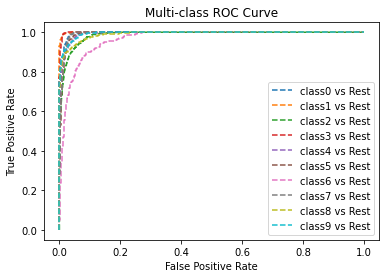

0.9912813082413846


In [24]:
#ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr={}
tpr={}
thresh={}
n_class = 10

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i], pos_label=i)

#print(fpr)

#plot
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle = '--', label=f"class{i} vs Rest")
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "best")
plt.show()

print(roc_auc_score(test_labels_list, test_outputs_list, multi_class='ovo', average='macro'))